How can we improve the efficiency of our supply chain?**

*   Analyze supplier performance and identify bottlenecks.
*   Optimize order fulfillment processes to reduce delivery times.

##File Overview:
1. Importing libraries and dataset selection
2. Dataset pre-processing
3. Generating new synthetic columns for dataset
4. Data Analysis and documentations of possible insights
5. References/sources used



##1. Importing libraries and reading datasets
To start off, we first import relevant libraries that we will be using for the cleaning & preparation of a dataset relevant to gaining insights for the question. Also, we will read in the appropriate datasets in answering our question.

For ensuring reproducibility of our analysis, we will be setting a seed as well.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt

# Set seed for reproducibility
seed_value = 52
np.random.seed(seed_value)

In [31]:
# Read in datasets that we will be using for our analysis
orders_dataset = pd.read_csv("orders.csv")
products_dataset = pd.read_csv("products_cleaned.csv")


##2. Data Pre-processing

For our question, we will try using columns from both the orders and products dataset. The final dataset after joining would contain the order and product details, which we will call as our deliveries dataset. This will be the main dataset on which we will be performing our analysis on.


In [32]:
# Combining the 2 datasets (order and products)
deliveries = pd.merge(orders_dataset, products_dataset, on='product_id')

To simplify our handling of the data structure and inspection for later, we will select columns that are relevant in answering the question.


In [33]:
deliveries = deliveries.loc[:, ['order_id', 'order_time', 'product_id', 'item_rating', 'seller_name', 'Ships_From', 'main_category']]

In [34]:
# We see what are the initial datatypes of the selected columns
print("Datatypes: ")
print(deliveries.dtypes)

Datatypes: 
order_id          int64
order_time       object
product_id        int64
item_rating      object
seller_name      object
Ships_From       object
main_category    object
dtype: object


Next, to ensure data compatibility and consistency, we will do the following:

i. Standardize data formats

ii. Resolve naming conventions

i. Standardizing data formats

We notice that under item_rating, there were some rows that do not have a rating, and is labelled as 'No ratings yet'

The former makes us not able to straight away standardize the column's datatype as a float

To resolve this issue, we imputed these deliveries with an item rating from 3-5 stars.

In [35]:
# We standardise all floats to be of 2 significant figures
pd.options.display.float_format = '{:.2f}'.format

# Handling of missing item ratings by randomizing within a set range
def randomize_missing_ratings(df, column='item_rating', min_rating=3.0, max_rating=5.0):
    # Fill missing ratings with random values within the specified range
    df[column] = df[column].apply(lambda x: x if pd.notnull(x) else np.random.uniform(min_rating, max_rating))
    df[column] = df[column].apply(lambda x: np.random.uniform(min_rating, max_rating) if x == 'No ratings yet' else x)
    return df

# Apply the functions to our dataset to fill up missing values
products_dataset = randomize_missing_ratings(products_dataset)

In [36]:
# Convert 'item_rating' column to numeric, handling errors by coercing to NaN
deliveries['item_rating'] = pd.to_numeric(deliveries['item_rating'], errors='coerce')

# Convert 'order_time' column to datetime format
deliveries['order_time'] = pd.to_datetime(deliveries['order_time'])

# Convert seller_name, Ships_From and main_category to type string
deliveries = deliveries.astype({
    'seller_name': 'string',  # Convert to string
    'Ships_From': 'string',   # Convert to string
    'main_category': 'string'  # Convert to string
})

ii. Resolving naming conventions

We standardised all column names to use snake case.
The only column that does not follow is 'Ships_From'.

In [37]:
# 2. Resolve naming conventions
# Rename column 'Ships_From' to 'shipped_from'
deliveries = deliveries.rename(columns={'Ships_From': 'shipped_from'})

After doing the two steps above, let's verify that our dataset have the appropriate datatypes and naming conventions.

In [38]:
# Checking if each column have the correct respective datatypes
print("Datatypes: ")
print(deliveries.dtypes)
print()

# Checking the first few rows of the dataset
deliveries.head()

Datatypes: 
order_id                  int64
order_time       datetime64[ns]
product_id                int64
item_rating             float64
seller_name      string[python]
shipped_from     string[python]
main_category    string[python]
dtype: object



,order_id,order_time,product_id,item_rating,seller_name,shipped_from,main_category
0,1,2019-12-22 08:16:00,15969,4.70,lihe15981868644.my,China,Women Clothes
1,2,2019-12-17 08:05:00,18176,4.90,rainbowperkahwinan.os,Malaysia,Home & Living
2,3,2019-11-08 11:08:00,9272,4.90,jpro_online,Malaysia,Health & Beauty
3,4,2019-11-21 20:12:00,8001,5.00,diamondshop88,Malaysia,Men Clothes
4,5,2019-11-16 08:13:00,16745,5.00,pediasure.os,Malaysia,Baby & Toys


##3. Generating synthetic columns




These 7 columns that you see above, however, are simply not sufficient to do a more in-depth analysis on the question. Recall, our question is about improving the efficiency of the supply chain, and we have chosen to focus on the return & reverse logistics stage in the supply chain given the severity of its costs (more details in wiki section 2). It is clear that we require a lot more columns that can give us more details to analyse the bottlenecks that are potentially causing higher return rates. Thereafter, we can suggest solutions that effectively target these causes.

Thus, in the subsequent code blocks, we work on generating synthetic columns for doing our analysis. To give an overview, here are the columns we are going to generate:
1. seller_rating
2. average_seller_response_time
3. delivery_time
4. return_request
5. late_delivery

We have also included our assumptions and explanations before the code blocks for each of the above column generated.

**1. seller_rating: Rating from 0-5 stars given to seller based on
seller's service**

Here, we assume that for each seller, their rating is the average item rating of all the items they have sold.

This helps us to provide an aggregate view of customer satisfaction, capturing how each seller performs generally across their products.
We will also be using the seller rating to generate other synthetic columns such as seller_response_time.

In [39]:
deliveries['seller_rating'] = deliveries.groupby('seller_name')['item_rating'].transform('mean')

**2. seller_response_time: Average time taken (in hours) for seller to respond to customer queries**

Here, we use our synthetic column 'seller_rating' to generate this synthetic column 'seller_response_time'.

We assume that generally speaking, the better the seller_rating (i.e closer to 5 stars), the better that seller's service is and the more likely they are to be responsive to customer queries, thus having a faster response time.

To do so, we split the seller_rating data into categories of how they are rated, and thereafter choose a random value from a reasonable range of values for that specific rating. For example, a seller with seller_rating of 5 stars have a response time between 0.01 - 0.5 hours.

Realistically, real-world data would have some level of noise and anomalies (i.e sellers who have low rating have fast response times)
Thus, here we introduce some outliers (e.g., very fast/slow response times) for certain sellers to improve the robustness and realism of our dataset.

In [40]:
def generate_seller_response_time(df):

    # The function response_time_by_rating takes in the seller_rating and outputs a random number from a set range of values for
    # that specific seller rating
    def response_time_by_rating(seller_rating):
        if seller_rating >= 5.0:
            return np.random.uniform(0.01, 0.5)
        elif seller_rating >= 4.9:
            return np.random.uniform(0.05, 1)
        elif seller_rating >= 4.8:
            return np.random.uniform(0.3, 2)
        elif seller_rating >= 4.7:
            return np.random.uniform(0.5, 4)
        elif seller_rating >= 4.6:
            return np.random.uniform(0.8, 8)
        elif seller_rating >= 4.5:
            return np.random.uniform(1, 16)
        elif seller_rating >= 4.4:
            return np.random.uniform(1.2, 32)
        elif seller_rating >= 4.3:
            return np.random.uniform(2.4, 35)
        elif seller_rating >= 4.2:
            return np.random.uniform(4.8, 38)
        elif seller_rating >= 4.1:
            return np.random.uniform(5, 40)
        elif seller_rating >= 4.0:
            return np.random.uniform(6, 50)
        else:
            return np.random.uniform(10, 80)

    # Apply the above function 'response_time_by_rating' to the dataset
    df['seller_response_time'] = df['seller_rating'].apply(response_time_by_rating)

    # Introduce noise and outliers/anomalies
    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'seller_response_time'] = df.loc[
                df['seller_name'] == seller, 'seller_response_time'
            ].apply(lambda x: x * np.random.uniform(0.2, 10))  # Multiply response time by a random factor

    return df

# We apply the above 'generate_seller_response_time' function to our dataset
deliveries = generate_seller_response_time(deliveries)

**3. delivery_time_in_days: Time taken (in days) for product to be delivered**

Here, we use 2 columns: item_rating & ship_from to generate this synthetic column

We assume that the item ratings are related to the delivery times, because in ecommerce settings, fast and reliable delivery can positively impact customer satisfaction. Ratings often reflect a combination of factors, and delivery time is a critical aspect of customer experience for online purchases. Thus, a higher item rating is likely to correspond to a faster delivery time.

Additionally, there is no doubt that if a product is shipped from some country further, it is likely that more time is needed to ship the product. For this reason, we add a random number from a set reasonable range to the delivery time for countries that are located further.

Once again, to enhance the realism of our synthetic data, we introduce some outliers (e.g., very long/short delivery times) for certain sellers
    
Eg. An item with a lower rating is delivered to the customer earlier than that of an item with higher rating

In [41]:
def generate_delivery_time(df):

    # Function that takes in the item_rating and outputs a random number from a set range corresponding to that specific item's rating
    # For example, an item rating of 5 stars would mean that the item takes about 1-3 days to be delivered to the customer
    def delivery_time_by_rating(item_rating):
        if item_rating >= 5.0:
            return np.random.uniform(1, 3)
        elif item_rating >= 4.9:
            return np.random.uniform(1, 3.5)
        elif item_rating >= 4.8:
            return np.random.uniform(1.5, 4)
        elif item_rating >= 4.7:
            return np.random.uniform(1.5, 4.5)
        elif item_rating >= 4.6:
            return np.random.uniform(2, 5)
        elif item_rating >= 4.5:
            return np.random.uniform(2, 5.5)
        elif item_rating >= 4.4:
            return np.random.uniform(2.5, 6)
        elif item_rating >= 4.3:
            return np.random.uniform(2.5, 6.5)
        elif item_rating >= 4.2:
            return np.random.uniform(3, 7)
        elif item_rating >= 4.1:
            return np.random.uniform(3, 7.5)
        elif item_rating >= 4.0:
            return np.random.uniform(3.5, 8)
        else:
            return np.random.uniform(7, 21)

    # We apply the above function 'delivery_time_by_rating' to each row of our dataset
    df['delivery_time'] = df['item_rating'].apply(delivery_time_by_rating)

    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'delivery_time'] = df.loc[
                df['seller_name'] == seller, 'delivery_time'
            ].apply(lambda x: x * np.random.uniform(0.5, 3))  # Multiply delivery time by a random factor

    # Adding additional delivery time in days based on ship_from column
    def add_delivery_time_by_ship_from(ship_from):
        if ship_from == 'China':
            return np.random.uniform(7, 14)
        elif ship_from == 'Indonesia':
            return np.random.uniform(3, 5)
        elif ship_from == 'Malaysia':
            return np.random.uniform(2, 4)
        elif ship_from == 'South Korea':
            return np.random.uniform(5, 10)
        elif ship_from == 'Taiwan':
            return np.random.uniform(5, 9)
        elif ship_from == 'Thailand':
            return np.random.uniform(3, 6)
        elif ship_from == 'Vietnam':
            return np.random.uniform(4, 7)

    # Applying the above functions to the dataset
    df['additional_delivery_time'] = df['shipped_from'].apply(add_delivery_time_by_ship_from)
    df['delivery_time'] = df['delivery_time'] + df['additional_delivery_time']

    return df

# We apply the above 'generate_delivery_time' function to our 2 datasets
deliveries = generate_delivery_time(deliveries)

**4. return_request: Boolean value indicating if customer requests for the product to be returned**

First, we defined reasonable return probabilities of each main category based on current trends. For example, the apparel category in recent years have been experiencing higher return rates (Adam, 2023), so we adjusted categories like Men's and Women's Clothes accordingly.

Here, we use both the item_rating and seller_rating (synthetic) to generate the synthetic column 'return_request'

We assume that both of these ratings can plausibly influence a customer's likelihood of returning a product.

Reason 1: Lower item_rating scores likely indicate that customers were dissatisfied with the product itself due to quality, performance or usability issues. Thus, dissatisfied customers are more prone to request returns.

Reason 2: Lower seller_rating could indicate issues with the seller's overall service, such as inaccurate product descriptions. This is likely to cause dissatisfied customers and thus likely for return requests.

Therefore, for products with lower item_rating & seller_rating, they have a higher probability for return_request to be True.

In [42]:
# Define return probabilities based on main_category
return_probabilities = {
    'Automotive': 0.08,
    'Baby & Toys': 0.12,
    'Cameras & Drones': 0.13,
    'Computer & Accessories': 0.13,
    'Fashion Accessories': 0.18,
    'Games, Books & Hobbies': 0.07,
    'Gaming & Consoles': 0.11,
    'Groceries & Pets': 0.03,
    'Health & Beauty': 0.13,
    'Home & Living': 0.11,
    'Home Appliances': 0.10,
    'Men Clothes': 0.30,
    'Men Shoes': 0.23,
    'Men’s Bags & Wallets': 0.13,
    'Mobile & Accessories': 0.12,
    'Others': 0.08,
    'Sports & Outdoor': 0.12,
    'Tickets & Vouchers': 0.02,
    'Travel & Luggage': 0.11,
    'Watches': 0.18,
    'Women Clothes': 0.35,
    'Women Shoes': 0.27,
    'Women’s Bags': 0.17
}

# Function to adjust return probability based on item rating
def calculate_adjusted_probability(base_prob, item_rating):
    # Define a scaling factor that reduces/increases probability based on rating
    # E.g., ratings < 3 increase return rate, while ratings >= 4.5 slightly reduce it
    if item_rating >= 5.0:
        adjusted_prob = (base_prob * np.random.uniform(0,0.5))
    elif item_rating >= 4.9:
        adjusted_prob = (base_prob * np.random.uniform(0.4,0.8))
    elif item_rating >= 4.8:
        adjusted_prob = (base_prob * np.random.uniform(0.4,0.9))
    elif item_rating >= 4.7:
        adjusted_prob = (base_prob * np.random.uniform(0.5,1.0))
    elif item_rating >= 4.6:
        adjusted_prob = (base_prob * np.random.uniform(0.5,1.1))
    elif item_rating >= 4.5:
        adjusted_prob = (base_prob * np.random.uniform(0.6,1.2))
    elif item_rating >= 4.4:
        adjusted_prob = (base_prob * np.random.uniform(0.6,1.3))
    elif item_rating >= 4.3:
        adjusted_prob = (base_prob * np.random.uniform(0.7,1.4))
    elif item_rating >= 4.2:
        adjusted_prob = (base_prob * np.random.uniform(0.8,1.5))
    elif item_rating >= 4.1:
        adjusted_prob = (base_prob * np.random.uniform(1,1.5))
    elif item_rating >= 4.0:
        adjusted_prob = (base_prob * np.random.uniform(1,2))
    else:
        adjusted_prob = np.random.uniform(2, 2.5)
    return min(max(adjusted_prob, 0), 1)

# Function to generate return request based on main_category and adjusted probabilities
def generate_return_request(row):
    main_cat = row['main_category']
    item_rating = row['item_rating']
    # Get base return probability for the category
    base_prob = return_probabilities.get(main_cat, 0.07)  # default probability if category not found
    # Adjust probability based on item rating
    adjusted_prob = calculate_adjusted_probability(base_prob, item_rating)
    # Generate return request based on adjusted probability
    return np.random.choice([True, False], p=[adjusted_prob, 1 - adjusted_prob])

# Apply the function to create the 'return_request' column
deliveries['return_request'] = deliveries.apply(generate_return_request, axis=1)

**5. late_delivery: Boolean value indicating if the delivery is late or not**

To generate data on whether a delivery will be late, we assume that countries that are further from Singapore would generally take more time to deliver goods, so we gave them a higher threshold accordingly. For example, China is the furthest from Singapore, and it has the highest threshold of 16.5.

We do acknowledge that this assumption does not take many other factors into account (eg. weather, peak seasons), and this is something we can consider for future work. For now, we would like to keep it simple as taking many different factors into account can make things complicated quickly.  

A delivery time above the specified threshold would be marked as 'late'.

In [43]:
# Define a dictionary to store the threshold for each country, using factor of 1.2
country_thresholds = {
    'China': 16.5,
    'Indonesia': 7.5,
    'Malaysia': 6.5,
    'South Korea': 12.5,
    'Taiwan': 11.5,
    'Thailand': 8.5,
    'Vietnam': 9.5,
}

def add_late_delivery_column(df):
  """
  Adds a 'late_delivery' column to the DataFrame, indicating whether the delivery time exceeds the threshold for the country.

  Args:
    df: The pandas DataFrame containing the dataset.

  Returns:
    The DataFrame with the added 'late_delivery' column.
  """
  df['late_delivery'] = False  # Initialize the column with False
  for country, threshold in country_thresholds.items():
    df.loc[(df['shipped_from'] == country) & (df['delivery_time'] > threshold), 'late_delivery'] = True
  return df

# Add the 'late_delivery' column to both datasets
deliveries = add_late_delivery_column(deliveries)

After generating the synthetic columns, let's look at the final version of the table that we will be using for our analysis.

In [44]:
deliveries

,order_id,order_time,product_id,item_rating,seller_name,shipped_from,main_category,seller_rating,seller_response_time,delivery_time,additional_delivery_time,return_request,late_delivery
0,1,2019-12-22 08:16:00,15969,4.70,lihe15981868644.my,China,Women Clothes,4.70,3.74,15.27,12.46,False,False
1,2,2019-12-17 08:05:00,18176,4.90,rainbowperkahwinan.os,Malaysia,Home & Living,4.89,0.89,5.30,2.67,False,False
2,3,2019-11-08 11:08:00,9272,4.90,jpro_online,Malaysia,Health & Beauty,4.92,0.82,3.34,2.14,False,False
3,4,2019-11-21 20:12:00,8001,5.00,diamondshop88,Malaysia,Men Clothes,5.00,0.15,4.25,3.07,False,False
4,5,2019-11-16 08:13:00,16745,5.00,pediasure.os,Malaysia,Baby & Toys,4.97,0.42,5.09,2.42,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91340,91341,2019-07-26 16:51:00,14069,4.60,nursery_pokok_bunga,Malaysia,Groceries & Pets,4.60,3.46,4.95,2.67,False,False
91341,91342,2019-08-01 08:49:00,9401,5.00,samugiken.os,Malaysia,Baby & Toys,4.94,8.13,6.80,2.23,False,True
91342,91343,2019-02-05 13:46:00,1241,5.00,pinkflash.os,China,Health & Beauty,4.93,0.53,12.90,11.66,False,False
91343,91344,2019-01-18 07:47:00,4466,4.90,icewatch.os,Malaysia,Watches,4.98,0.92,4.78,2.79,False,False


## 4. Data Analysis
In this section, we will be plotting graphs, discussing our thoughts on the observations and potential implications of the observations.

We start off our analysis with a correlation matrix. This is beneficial in the sense that we can quickly uncover any strength and direction of linear relationships between pairs of variables. Also, we can detect multicollinearity, where 2 or more variables are closely related. This is helpful for our analysis on uncovering the reasons of what causes high return rates.

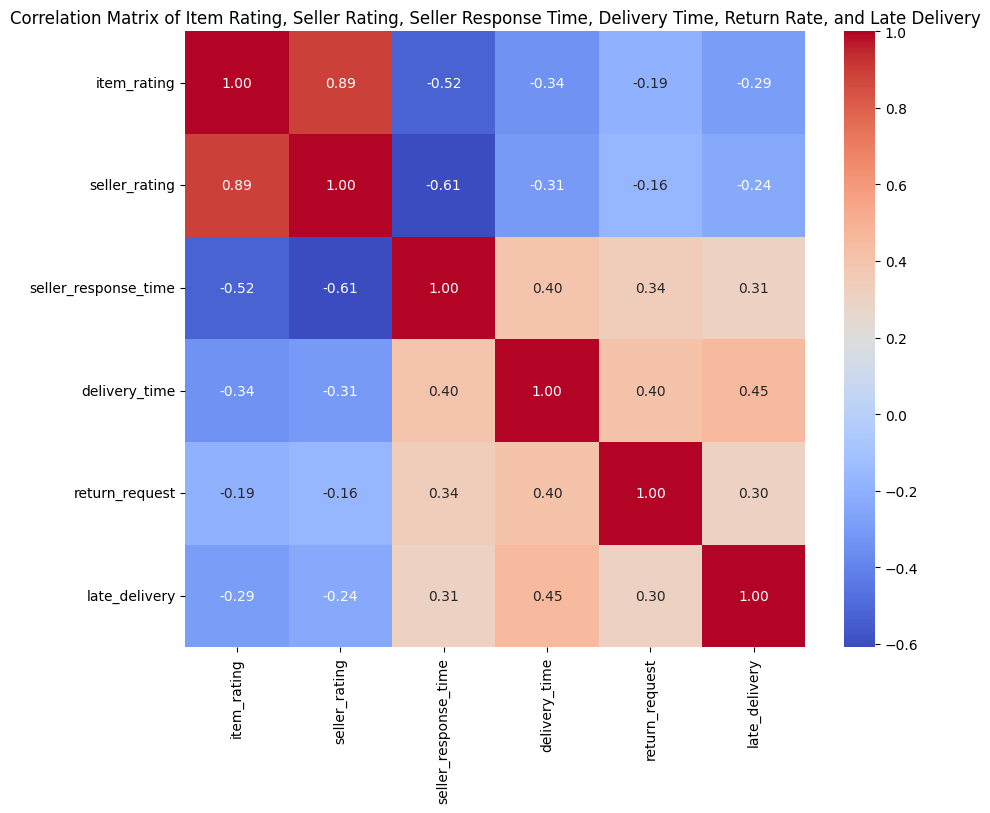

In [45]:
# Selecting columns we want to visualise in the correlation matrix
correlation_data = deliveries[['item_rating', 'seller_rating', 'seller_response_time', 'delivery_time', 'return_request', 'late_delivery']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap visualization using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Item Rating, Seller Rating, Seller Response Time, Delivery Time, Return Rate, and Late Delivery')
plt.show()

Our primary observations of the correlation matrix are:
- There is a moderate positive correlation between delivery time and return request: This means that generally, the longer the delivery time, the more likely a return is requested
- The correlation coefficient of delivery time vs return request and seller response time vs return request are quite similar. This could be highlighting that there are many different factors that come into play for higher return rates

Next, we plotted a graph that visualises order volume, return volume and return rate by main category of products.

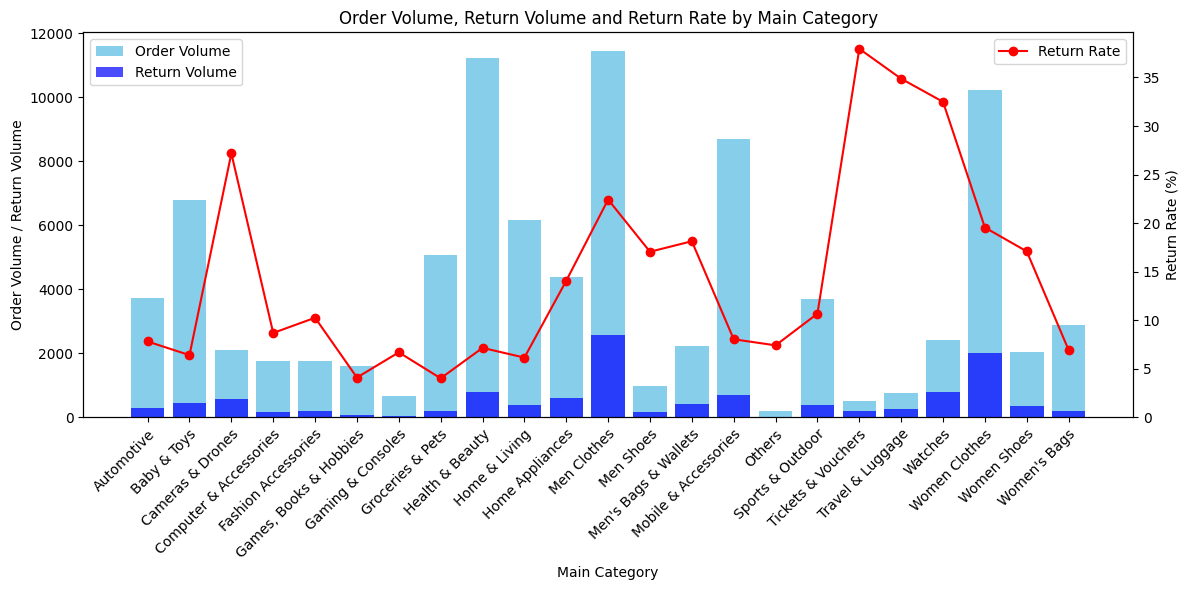

In [46]:
# Group data by main category and calculate relevant metrics
category_metrics = deliveries.groupby('main_category').agg(
    order_volume=('order_id', 'count'),
    return_volume=('return_request', 'sum')
)
category_metrics['return_rate'] = (category_metrics['return_volume'] / category_metrics['order_volume']) * 100

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot order volume and return volume on the left y-axis
ax1.bar(category_metrics.index, category_metrics['order_volume'], label='Order Volume', color='skyblue')
ax1.bar(category_metrics.index, category_metrics['return_volume'], label='Return Volume', color='blue', alpha=0.7)
ax1.set_xlabel('Main Category')
ax1.set_ylabel('Order Volume / Return Volume')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create a second y-axis for return rate
ax2 = ax1.twinx()
ax2.plot(category_metrics.index, category_metrics['return_rate'], label='Return Rate', color='red', marker='o')
ax2.set_ylabel('Return Rate (%)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# Set y-axis limits to start from 0
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add a title
plt.title('Order Volume, Return Volume and Return Rate by Main Category')

# Display the plot
plt.tight_layout()
plt.show()

Our primary observations are:
- Items that are under the category of clothes and health & beauty are more popular among customers, as seen from their high order volume compared to other categories
- The categories with the highest return rates are Men's Clothes and Women's Clothes. They also have a relatively high return rate.

Earlier, we did see from the correlation matrix that later delivery times are somewhat associated higher return rates. We also saw that Men's Clothes had a relatively high return rate. So, we plotted the return rate against the delivery status (late vs early) to verify our observations.

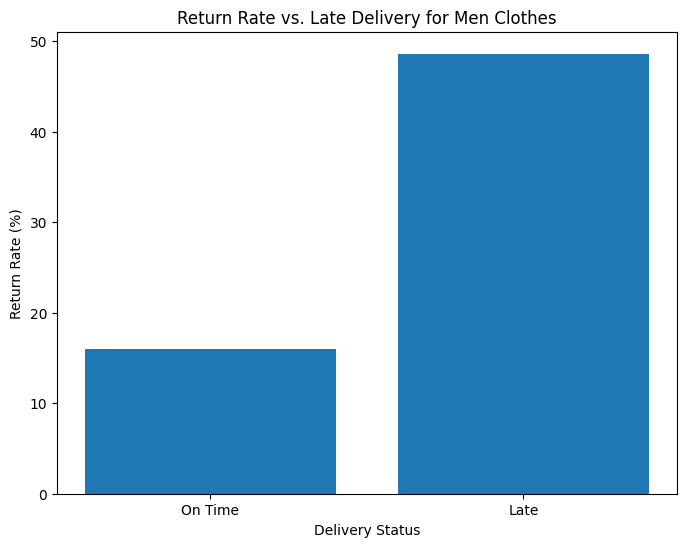

In [47]:
# Filter for 'Men Clothes' category
men_clothes_df = deliveries[deliveries['main_category'] == 'Men Clothes']

# Calculate the return rate for each combination of late delivery and main category
return_rate_by_late_delivery = men_clothes_df.groupby('late_delivery')['return_request'].mean()

# Replace 'False' and 'True' with "On Time" and "Late" for better clarity
return_rate_by_late_delivery.index = return_rate_by_late_delivery.index.map({False: 'On Time', True: 'Late'})

# Convert return rate to percentage
return_rate_by_late_delivery = return_rate_by_late_delivery * 100

# Create a bar chart visualization
plt.figure(figsize=(8, 6))
plt.bar(return_rate_by_late_delivery.index, return_rate_by_late_delivery.values)
plt.xlabel('Delivery Status')
plt.ylabel('Return Rate (%)')
plt.title('Return Rate vs. Late Delivery for Men Clothes')
plt.show()

We see a very strong general trend that the high return rate was associated with late delivery times. For those that were on time but yet returned, we hypothesise that it can be due to customer's preferences and expectations.

We were interested in looking into what might have caused the late deliveries. We decide to look into the average delivery time for each country, as well as their return rate.

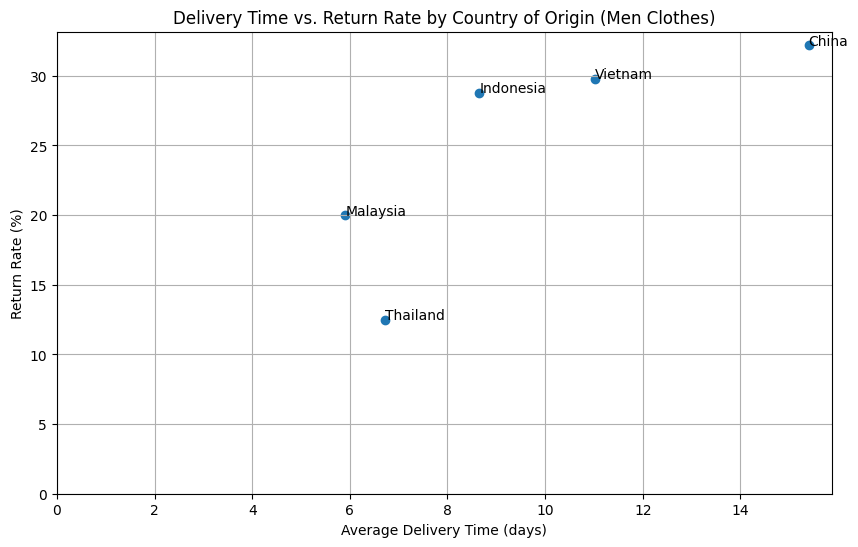

In [48]:
men_clothes_df = deliveries[deliveries['main_category'] == 'Men Clothes']

# Group by 'Ships_From' and calculate the average delivery time and return rate for each country.
delivery_time_and_return_rate_by_country = men_clothes_df.groupby('shipped_from').agg({'delivery_time': 'mean', 'return_request': 'mean'})

# Create a scatter plot visualization.
plt.figure(figsize=(10, 6))
plt.scatter(delivery_time_and_return_rate_by_country['delivery_time'], delivery_time_and_return_rate_by_country['return_request'] * 100)  # Multiply return_request by 100 to show percentage
plt.xlabel('Average Delivery Time (days)')
plt.ylabel('Return Rate (%)')
plt.title('Delivery Time vs. Return Rate by Country of Origin (Men Clothes)')
plt.grid(True)

# Set axis to start from zero
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add country labels to the points (optional).
for country, row in delivery_time_and_return_rate_by_country.iterrows():
  plt.annotate(country, (row['delivery_time'], row['return_request'] * 100))

plt.show()

We observe that further countries from Singapore like China and Vietnam had really high average delivery times and a high return rate as well. So delivery time could be playing a really crucial role in determining if a product will be returned. Further countries, even though expected to have longer delivery times, aren't excused from their distance for late deliveries. Thus, it might be important for countries to find ways to shorten the delivery times, even for faraway countries.

We want to delve further into not only the country, but also the return rates for different segments of delivery time by each country.

C:\Users\sawyf\AppData\Local\Temp\ipykernel_12352\1736640537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_clothes_df['delivery_time_segment'] = pd.cut(men_clothes_df['delivery_time'], bins=bins, labels=labels, right=False)
C:\Users\sawyf\AppData\Local\Temp\ipykernel_12352\1736640537.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return_rate_by_country_and_segment = men_clothes_df.groupby(['shipped_from', 'delivery_time_segment'])['return_request'].mean().unstack()


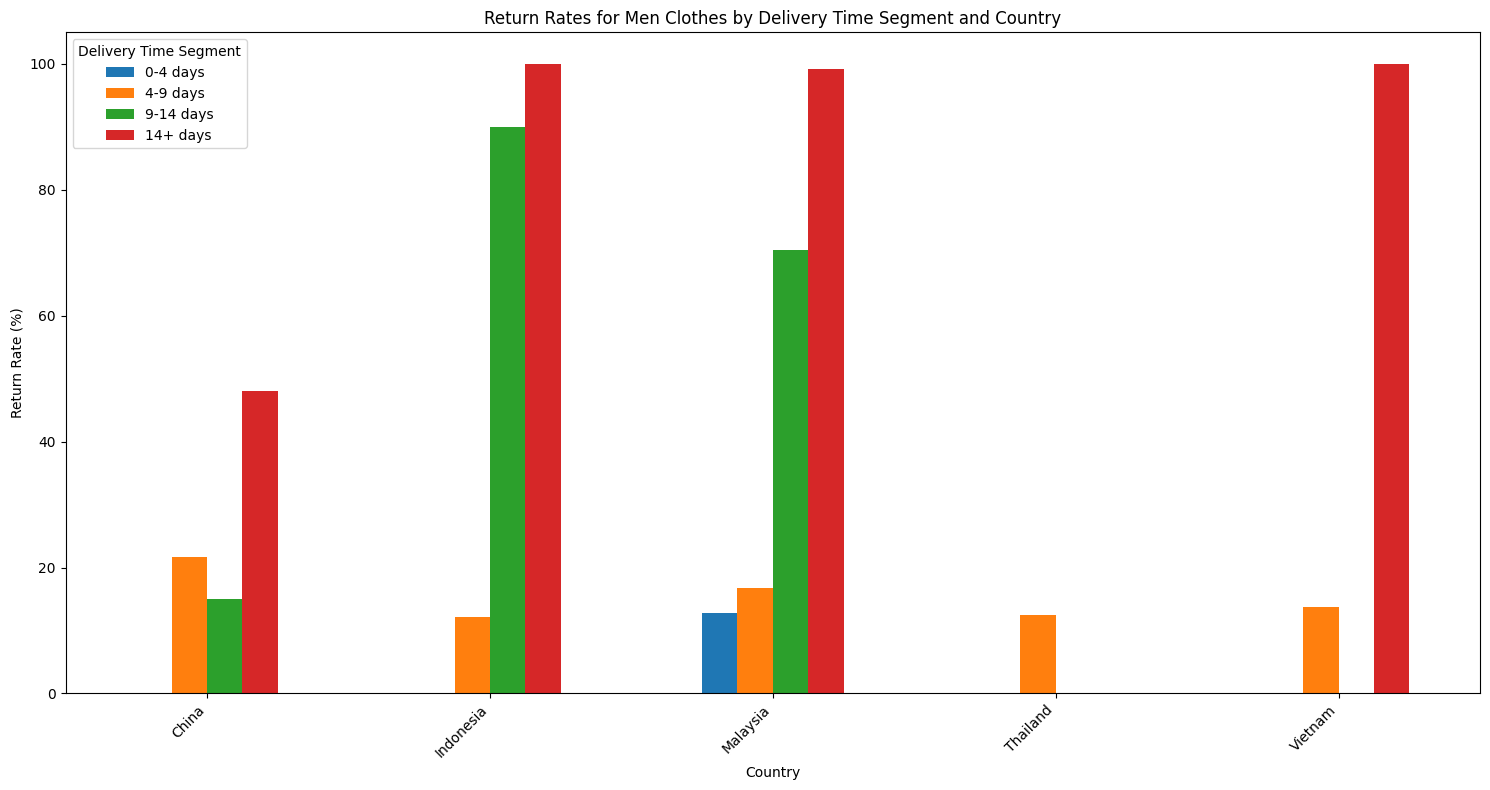

In [49]:
# Filter for 'Men Clothes' category.
men_clothes_df = deliveries[deliveries['main_category'] == 'Men Clothes']

# Create bins for delivery time segments
bins = [0, 4, 9, 14, float('inf')]
labels = ['0-4 days', '4-9 days', '9-14 days', '14+ days']
men_clothes_df['delivery_time_segment'] = pd.cut(men_clothes_df['delivery_time'], bins=bins, labels=labels, right=False)

# Group by country and delivery time segment, then calculate the return rate.
return_rate_by_country_and_segment = men_clothes_df.groupby(['shipped_from', 'delivery_time_segment'])['return_request'].mean().unstack()

# Multiply return rates by 100 to express them as percentages.
return_rate_by_country_and_segment = return_rate_by_country_and_segment * 100

# Plot the return rates for each country across different delivery time segments
return_rate_by_country_and_segment.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Country')
plt.ylabel('Return Rate (%)')
plt.title('Return Rates for Men Clothes by Delivery Time Segment and Country')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Delivery Time Segment')
plt.tight_layout()
plt.show()

We can observe that even countries like Malaysia, which is very near to Singapore, also have exceedingly high return rates when the products get delivered later. We can compare Malaysia and China to visualise this. So China is further, and longer delivery times are expected, which is why return rates are lower even though it takes the same amount of days as say Malaysia.

This could be customer's expectations of how fast a good would be delivered from a specific country, depending on how near it is to Singapore. The general consensus is definitely nearer countries have less of an excuse to be late. Thus, it can be very important for ecommerce companies to ensure that goods delivered from nearer/neighbouring countries be as early as possible.

We now want to look into other factors that could be causing higher return rates. The other factor based on the correlation matrix that caught our eye is seller response time. Thus, we want to see how seller response time correlates with return rates generally.

C:\Users\sawyf\AppData\Local\Temp\ipykernel_12352\3542332381.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


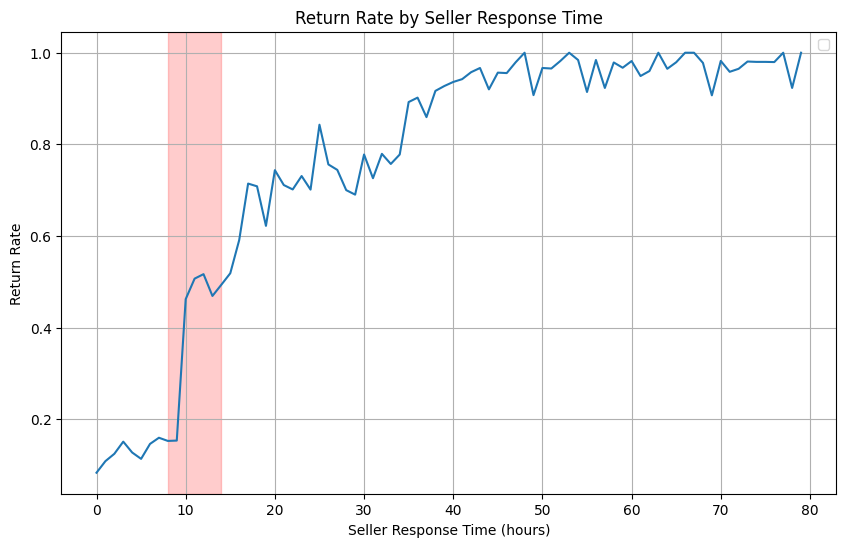

In [50]:
# Group data by seller response time (binned by hours) and calculate the return rate
deliveries['seller_response_time_bin'] = (deliveries['seller_response_time'] // 1).astype(int)  # Bin by hours
return_rate_by_response_time = deliveries.groupby('seller_response_time_bin')['return_request'].mean()

# Filter the data to include only response times up to 80 hours
return_rate_by_response_time = return_rate_by_response_time[return_rate_by_response_time.index <= 80]

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(return_rate_by_response_time.index, return_rate_by_response_time.values)
plt.xlabel("Seller Response Time (hours)")
plt.ylabel("Return Rate")
plt.title("Return Rate by Seller Response Time")
plt.grid(True)

# Add a red box highlighting the range 8-14 hours
plt.axvspan(8, 14, color='red', alpha=0.2)
plt.legend()

plt.show()

As expected, the general trend is clear. The longer the seller takes to respond, the higher the odds of returns. Notice that at the highlighted area (i.e 8-14 hour mark), there is a steep increase in return rates. It could be highlighting the patience threshold of customers on average. So, if companies want to reduce return rates, perhaps it is important to ensure sellers try to respond before this range of time.

Next, we also plotted seller response times against the average number of orders they have monthly. We wanted to explore if seller response times are influenced by the number of orders that they have generally.

C:\Users\sawyf\AppData\Local\Temp\ipykernel_12352\3756552139.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seller_months = deliveries.groupby('seller_name').apply(calculate_months)


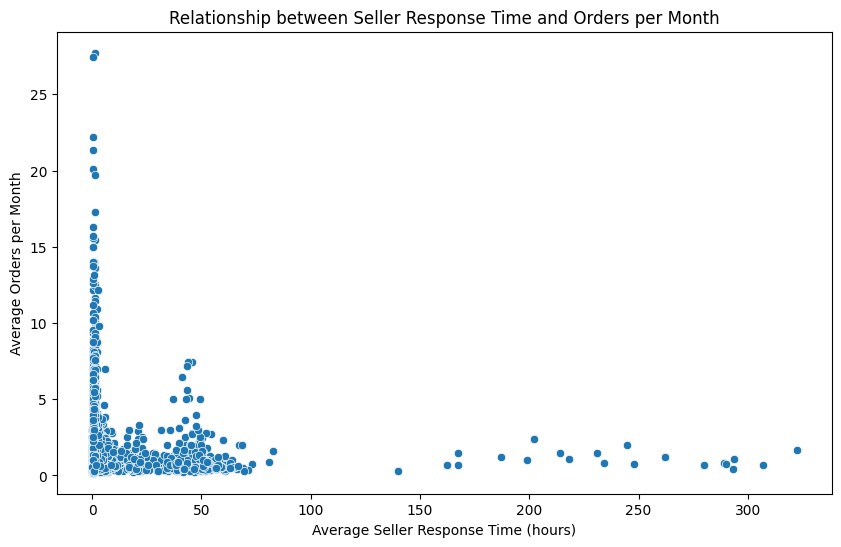

In [51]:
# Convert 'order_time' to datetime if it's not already
deliveries['order_time'] = pd.to_datetime(deliveries['order_time'])

# Calculate the number of months for each seller
def calculate_months(seller_data):
    min_date = seller_data['order_time'].min()
    max_date = seller_data['order_time'].max()
    months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month)
    return months

seller_months = deliveries.groupby('seller_name').apply(calculate_months)

# Calculate orders per month for each seller
deliveries['orders_per_month'] = deliveries['seller_name'].map(
    deliveries.groupby('seller_name').size() / seller_months
)

# Group data by seller and calculate the mean response time and orders per month
seller_stats = deliveries.groupby('seller_name').agg(
    {'seller_response_time': 'mean', 'orders_per_month': 'mean'}
)

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='seller_response_time', y='orders_per_month', data=seller_stats)
plt.xlabel("Average Seller Response Time (hours)")
plt.ylabel("Average Orders per Month")
plt.title("Relationship between Seller Response Time and Orders per Month")
plt.show()

We observe that generally speaking, the lower the number of orders a seller has, the faster the response times, as seen in the huge cluster of points (each point represents a seller) in the bottom left of the graph. This could be that they are less busy and can easily manage with fewer orders, thus being able to respond promptly. On the other hand, sellers who are overwhelmed with orders might be less available to respond to customers.

We were curious in seeing how each country fared in terms of their late deliveries.

Percentage of Late Deliveries Across Countries:
shipped_from
China         14.68
Indonesia     32.81
Malaysia      16.56
South Korea    2.73
Taiwan        52.08
Thailand      14.29
Vietnam       42.46
Name: late_delivery, dtype: float64


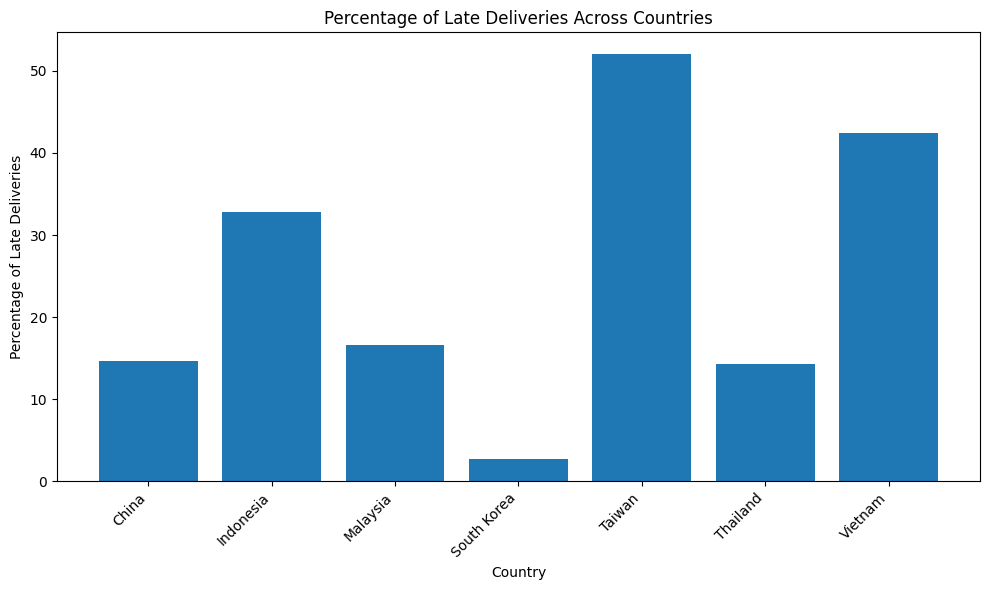

In [52]:
# Group by country and calculate the percentage of late deliveries
late_delivery_percentage_by_country = deliveries.groupby('shipped_from')['late_delivery'].mean() * 100

# Print the results
print("Percentage of Late Deliveries Across Countries:")
print(late_delivery_percentage_by_country)

# Optionally, create a bar chart to visualize the results
plt.figure(figsize=(10, 6))
plt.bar(late_delivery_percentage_by_country.index, late_delivery_percentage_by_country.values)
plt.xlabel("Country")
plt.ylabel("Percentage of Late Deliveries")
plt.title("Percentage of Late Deliveries Across Countries")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

From this, we can gauge how efficient deliveries from a country are. If they are located further from Singapore and still keep up with a relatively low percentage of late deliveries, it means that companies are good in setting customer's expectations of how fast a product will be delivered from a specific country. Or, it could also be that the business is doing well in the supply chain of goods from that country to Singapore. So, it would be wise to divert resources to increase the efficiency for countries performing worse.

#References

Wilson, A. (2023a, May 17). The impact of eCommerce return rate on your business. Medium. https://medium.com/@adamwilsonwebmaxy/the-impact-of-ecommerce-return-rate-on-your-business-97ff9a3e2e95